## European options pricing
In this notebook, we will present different methods for pricing options.

Option contracts are a financial derivative that represents the right, but not the obligation, to buy (call) or sell (put) a particular security on (European type) or before (American type) an expiration date.
A subset of these instruments were first priced with the Black-Scholes Equation :
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0
$$
The formula assumes no dividends, constant volatility, and a lognormal distribution of stock prices.

The formula for Black-Scholes for pricing a European call option
$$
C = S \cdot \Phi(d_1) - X e^{-rT} \cdot \Phi(d_2)
$$

with 

$$
d_1 = \frac{\ln(S/X) + (r + \sigma^2 / 2) T}{\sigma \sqrt{T}}, \quad d_2 = d_1 - \sigma \sqrt{T},
$$

and $\Phi(\cdot)$ as the cumulative density function of the standard normal distribution. The inputs are $S$ the underlying price, $X$ the exercise price, $T$ the annualized fraction of time until expiration, $r$ the risk-free interest rate, and $\sigma$ the standard deviation of stock price returns.

We will import essential libraries for data visualization $\textbf{matplotlib}$ , numerical computations $\textbf{numpy}$ , deep learning $ \textbf{torch}$ , and data preprocessing $\textbf{sklearn}$. 

In [2]:
!pip install torch

   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/241.3 MB 2.9 MB/s eta 0:01:24
   ---------------------------------------- 0.3/241.3 MB 3.9 MB/s eta 0:01:02
   ---------------------------------------- 0.5/241.3 MB 5.2 MB/s eta 0:00:47
   ---------------------------------------- 1.0/241.3 MB 6.1 MB/s eta 0:00:40
   ---------------------------------------- 1.2/241.3 MB 6.1 MB/s eta 0:00:40
   ---------------------------------------- 1.4/241.3 MB 5.8 MB/s eta 0:00:42
   ---------------------------------------- 1.4/241.3 MB 5.0 MB/s eta 0:00:48
   ---------------------------------------- 2.0/241.3 MB 6.1 MB/s eta 0:00:40
   ---------------------------------------- 2.3/241.3 MB 6.2 MB/s eta 0:00:39
   ---------------------------------------- 2.6/241.3 MB 6.5 MB/s eta 0:00:37
   ---------------------------------------- 3.0/241.3 MB 6.5 MB/s eta 0:00:37
    --------------------------------------- 3.2/241.3 MB 6.7 MB/s eta 0

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

In [4]:
class AmericanOptions:
    def __init__(self, r, sigma):
        self.sigma = sigma
        self.r = r

    def __call__(self, T, n, S0):
        dt = T / n  # Time step
        Z = np.random.normal(0, 1, n)  # Brownian motion increments
        S = [S0]  # Store stock prices
        
        for i in range(n):  # Iterate n times
            S_next = S[-1] * np.exp((self.r - 0.5 * self.sigma**2) * dt + self.sigma * np.sqrt(dt) * Z[i])  #Brownian Motion 
            S.append(S_next)
        
        return np.array(S)  # Convert list to numpy array

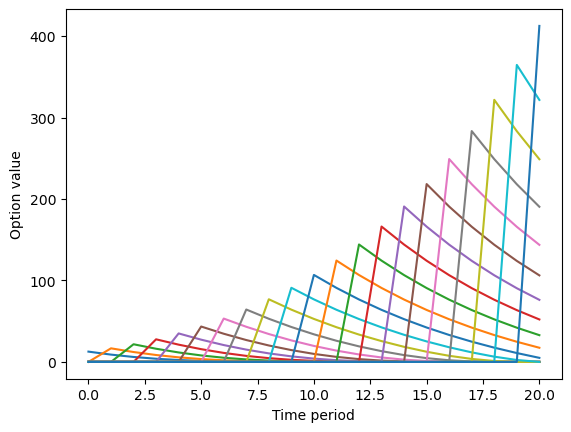

In [5]:
def binomial_option_values(S, K, r, T, N, sigma, option_type):
    """
    S: current price of the underlying asset
    K: Strike price of the option
    r: risk-free interest rate
    T: time to expiration of the option (in years)
    N: number of time periods in the binomial model
    option_type: "call" or "put"
    """
    dt = T / N  # Time step
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Initialize the 2D array to store option values
    values = np.zeros((N + 1, N + 1))

    # Compute asset prices at expiration 
    j = np.arange(N + 1)  # Array of indices [0, 1, ..., N]
    asset_prices = S * (u ** j) * (d ** (N - j))  # Asset prices at expiration

    # Calculate option values at expiration
    if option_type == "call":
        values[N, :] = np.maximum(0, asset_prices - K)
    elif option_type == "put":
        values[N, :] = np.maximum(0, K - asset_prices)
    # Backward induction to compute option values at earlier time steps
    for i in range(N - 1, -1, -1):
        values[i, :i + 1] = np.exp(-r * dt) * (
            p * values[i + 1, 1:i + 2] + (1 - p) * values[i + 1, :i + 1]
        )

    return values

# Example usage:
S = 50
K = 45
r = 0.05
T = 0.5
N = 20
sigma = 0.7
option_type = "call"

option_values = binomial_option_values(S, K, r, T, N, sigma, option_type)

# Plot the option values over time
plt.plot(option_values)
plt.xlabel("Time period")
plt.ylabel("Option value")
plt.show()

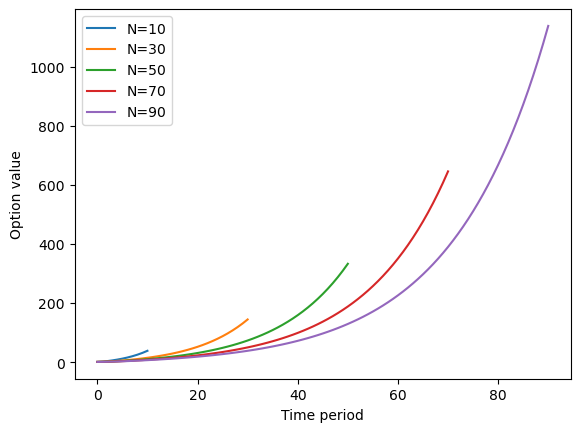

In [6]:
def pay(K, N, a, b, r, S=1):
    values = np.zeros((N + 1, N + 1))
    
    # Base case: Compute final step values
    j = np.arange(N + 1)
    x_vals = S * (1 + a) ** j * (1 + b) ** (N - j)
    values[N, :] = np.maximum(x_vals-K, 0)
    
    p = (r - a) / (b - a)  # Risk-neutral probability
    
    for i in range(N - 1, -1, -1):
        j = np.arange(i + 1)
        x_vals = S * (1 + a) ** j * (1 + b) ** (i - j)
        expected = (p * values[i + 1, 1:i + 2] + (1 - p) * values[i + 1, :i + 1]) / (1 + r)
        values[i, :i + 1] = np.maximum(np.maximum(x_vals-K, 0), expected)
    
    return values

def binomial(sigma, T, N, R, K, S=1):
    dt = T / N
    r = R * dt  # Per-period interest rate
    a = np.exp(-sigma * np.sqrt(dt)) - 1
    b = np.exp(sigma * np.sqrt(dt)) - 1
    return pay(K, N, a, b, r, S)
# Parameters
S = 10
K = 10
r = 0.5
T = 1
sigma = 0.5
# Plot for different N values
for N in range(10, 100, 20):
    option_values = binomial(sigma=sigma, T=T, N=N, R=r, K=K, S=S)
    plt.plot(option_values[:, 0], label=f"N={N}")
plt.xlabel("Time period")
plt.ylabel("Option value")
plt.legend()
plt.show()

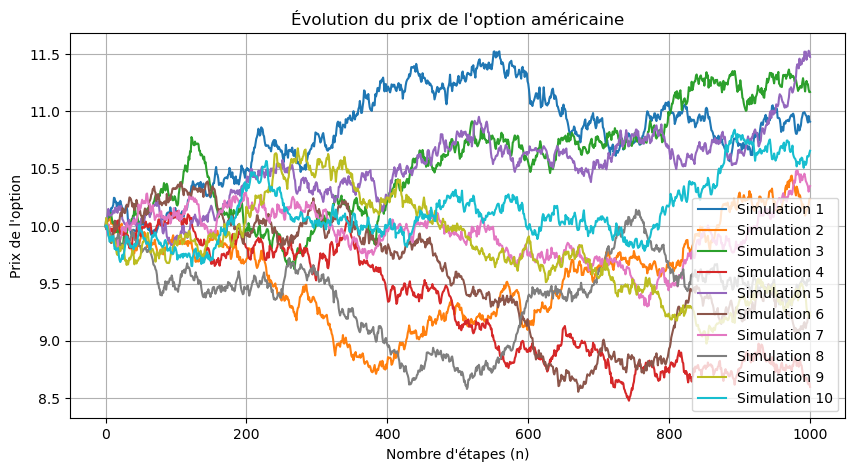

In [7]:
N = 10
n = 1000
plt.figure(figsize=(10, 5))
for _ in range(N):
    option = AmericanOptions(r=0.05, sigma=0.1)
    prices = option(T=1, n=n, S0=10)
    plt.plot(range(n + 1), prices, label=f"Simulation {_ + 1}")
# Ajout de titres et labels
plt.title("Évolution du prix de l'option américaine")
plt.xlabel("Nombre d'étapes (n)")
plt.ylabel("Prix de l'option")
plt.legend()
plt.grid(True)
plt.show()

We are going to implement the Longstaff-Schwartz Monte Carlo method for pricing American options. This approach relies on backward induction and utilizes Laguerre polynomials to approximate the continuation value of the option at each time step. The following sections provide a detailed explanation of the implementation.

In [8]:
def payoff(S,K) :
    return np.maximum(K-S,0)

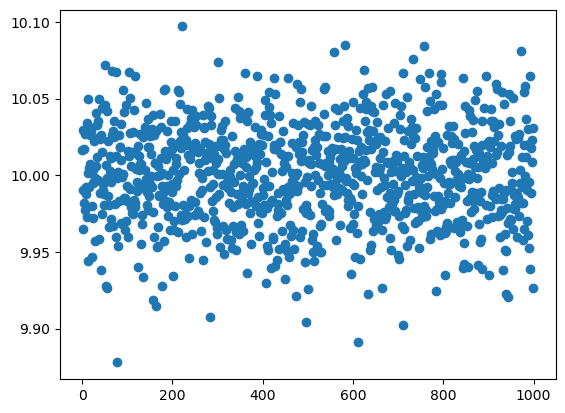

In [9]:
N = 1000
n = 1000
S0 = 10
r = 0.05
sigma = 0.1
T = 1
simulations = [] 

for _ in range(N):
    option = AmericanOptions(r=r, sigma=sigma)
    prices = option(T=T, n=n, S0=S0)
    simulations.append(prices)

# Convert the list to a NumPy array
S= np.array(simulations)
V = np.zeros((N,n+1))
K = S0
V[:, -1] = payoff(S[:, -1], K)
S1 = S[:,1]
len(S1)
plt.scatter(range(0,N),S1)
plt.show()


In [10]:
dt = T/n
# Backward Induction
for i in range(n-1, 0, -1):  # Iterate backwards from the second last time step
    S_i = S[:, i]
    V_i_1 = V[:, i+1]
    V_i = np.exp(-r * dt) * V_i_1  # Discounted future value
    
    # Fit continuation value using Laguerre polynomials
    fit = np.polynomial.Laguerre.fit(S_i, V_i, deg=5)  # Choose degree 3
    # Compute continuation value
    continuation_value = fit(S_i)

    # Immediate exercise value
    exercise_value = payoff(S_i, K)

    # Apply early exercise condition
    V[:, i] = np.where(exercise_value > continuation_value, exercise_value, V_i)

# Compute option price (discounted expectation)
option_price = np.exp(-r * dt) * np.mean(V[:, 1])

print(f"American Option Price: {option_price:.4f}")

American Option Price: 0.2559


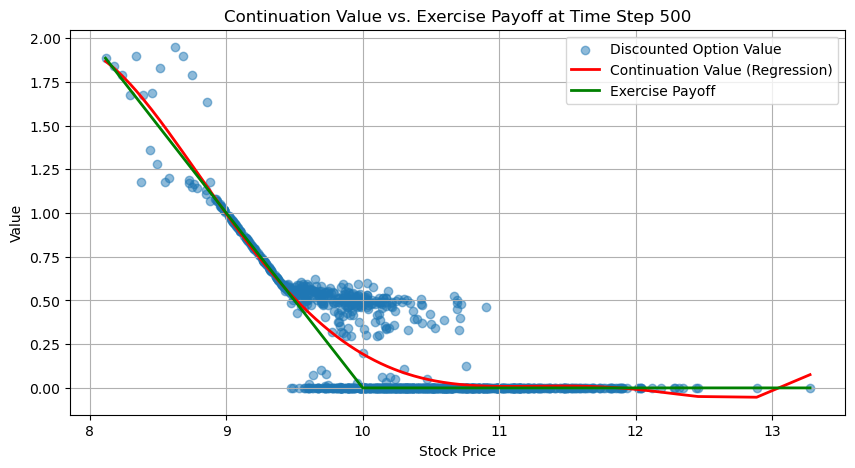

In [11]:
i = n // 2  # Pick a mid-time step
S_i = S[:, i]
V_i = V[:, i]
fit = np.polynomial.Laguerre.fit(S_i, V_i, deg=5)  # Regression fit
continuation_value = fit(S_i)
exercise_value = payoff(S_i, K)

plt.figure(figsize=(10, 5))
plt.scatter(S_i, V_i, label="Discounted Option Value", alpha=0.5)
plt.plot(np.sort(S_i), fit(np.sort(S_i)), label="Continuation Value (Regression)", color="red", linewidth=2)
plt.plot(np.sort(S_i), payoff(np.sort(S_i), K), label="Exercise Payoff", color="green", linewidth=2)
plt.xlabel("Stock Price")
plt.ylabel("Value")
plt.title(f"Continuation Value vs. Exercise Payoff at Time Step {i}")
plt.legend()
plt.grid()
plt.show()


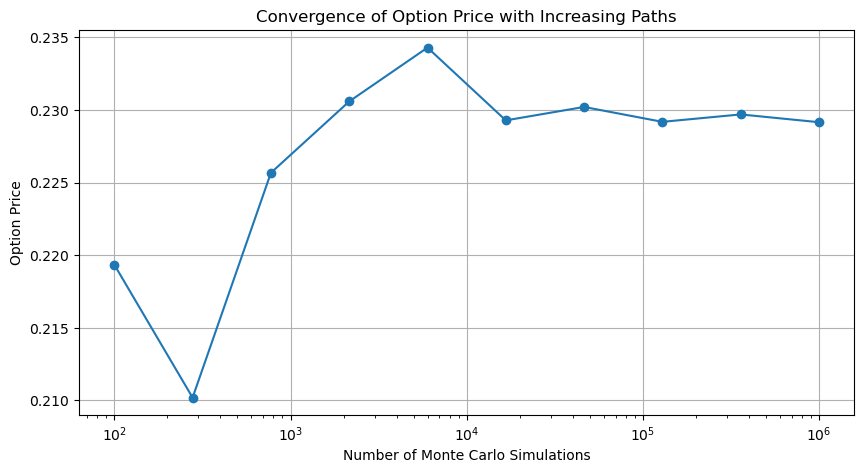

In [12]:
num_paths = np.logspace(2, 6, 10, dtype=int)  # Vary number of paths
option_prices = []

for N_test in num_paths:
    S_test = np.zeros((N_test, n+1))
    S_test[:, 0] = S0
    for i in range(1, n+1):
        Z = np.random.normal(size=N_test)
        S_test[:, i] = S_test[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    V_test = np.zeros_like(S_test)
    V_test[:, -1] = payoff(S_test[:, -1], K)

    for i in range(n-1, 0, -1):
        S_i = S_test[:, i]
        V_i = np.exp(-r * dt) * V_test[:, i+1]
        fit = np.polynomial.Laguerre.fit(S_i, V_i, deg=3)
        continuation_value = fit(S_i)
        V_test[:, i] = np.where(payoff(S_i, K) > continuation_value, payoff(S_i, K), V_i)

    option_price = np.exp(-r * dt) * np.mean(V_test[:, 1])
    option_prices.append(option_price)

plt.figure(figsize=(10, 5))
plt.plot(num_paths, option_prices, marker='o', linestyle='-')
plt.xscale("log")
plt.xlabel("Number of Monte Carlo Simulations")
plt.ylabel("Option Price")
plt.title("Convergence of Option Price with Increasing Paths")
plt.grid()
plt.show()


We Observe that by increasing the number of Monte Carlo Simulations The option Pricing is becoming more stable.

Now we are going to use Neural Networks for Option Pricing.

We are going to train a neural network to predict call option prices using the Black-Scholes model. It generates synthetic data (stock price, strike, time, interest rate, volatility) and computes true prices using the Black-Scholes formula. A 4-layer neural network learns to approximate these prices, achieving close matches to the theoretical values. The model is trained on 80% of the data and tested on 20%, demonstrating how AI can replicate complex financial math.

In [13]:
# Black-Scholes Call Price Calculation
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Generate Synthetic Data
np.random.seed(42)
num_samples = 100000
S = np.random.uniform(50, 150, num_samples)
K = np.random.uniform(50, 150, num_samples)
T = np.random.uniform(0.1, 2.0, num_samples)
r = np.random.uniform(0.01, 0.10, num_samples)
sigma = np.random.uniform(0.1, 0.5, num_samples)
call_prices = black_scholes(S, K, T, r, sigma)

# Combine features and normalize
X = np.column_stack((S, K, T, r, sigma))
y = call_prices.reshape(-1, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split into train/test sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Neural Network
class PricingNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PricingNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    
    # Print losses
    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

# Example Prediction
model.eval()
sample_input = torch.tensor(scaler.transform([[100.0, 100.0, 1.0, 0.05, 0.2]]), dtype=torch.float32).to(device)
predicted_price = model(sample_input).item()
actual_price = black_scholes(100.0, 100.0, 1.0, 0.05, 0.2)

print(f"\nPredicted Price: {predicted_price:.4f}")
print(f"Black-Scholes Price: {actual_price:.4f}")

Epoch 1/10 | Train Loss: 17.754978 | Test Loss: 0.080119
Epoch 2/10 | Train Loss: 0.069896 | Test Loss: 0.043550
Epoch 3/10 | Train Loss: 0.059090 | Test Loss: 0.097250
Epoch 4/10 | Train Loss: 0.074626 | Test Loss: 0.035299
Epoch 5/10 | Train Loss: 0.073519 | Test Loss: 0.097793
Epoch 6/10 | Train Loss: 0.049378 | Test Loss: 0.019208
Epoch 7/10 | Train Loss: 0.049552 | Test Loss: 0.024158
Epoch 8/10 | Train Loss: 0.046435 | Test Loss: 0.034945
Epoch 9/10 | Train Loss: 0.048435 | Test Loss: 0.171323
Epoch 10/10 | Train Loss: 0.039917 | Test Loss: 0.016091

Predicted Price: 10.4374
Black-Scholes Price: 10.4506
